In [5]:
%matplotlib inline

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'analysis'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'session'))

import numpy as np
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from target import build_tgt_matrix
np.set_printoptions(suppress=True)

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 2.1 A1 single units exhibit micro-structure in response to target / background

In [48]:
def get_spike_counts(spk_times, pulse_times, hw=0.25, bin_count=51):
    collected = []
    for t_pulse in pulse_times:
        selected = spk_times[(spk_times > t_pulse - hw) & (spk_times < t_pulse + hw)]
        collected += [x for x in selected - t_pulse]
    collected = np.array(collected)

    bins = np.linspace(-hw, hw, bin_count)
    counts, _ = np.histogram(collected, bins=bins)
    counts = (counts / len(pulse_times))# * 1/((2. * hw)/float(bin_count - 1))
    
    return bins, counts

In [49]:
source = '/home/sobolev/nevermind/Andrey/data'
area = 'A1'
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': ['1-2', '1-4', '1-5', '1-6', '1-10', '1-12', '1-13', '1-14', '2-2'],
    '009266_hippoSIT_2023-04-18_10-10-37': ['1-12', '1-13', '1-6', '2-12', '2-13', '2-14', '2-5', '2-7', '2-8'],
    '009266_hippoSIT_2023-04-18_17-03-10': ['1-18', '1-7', '2-2', '2-3', '2-11'],
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

23

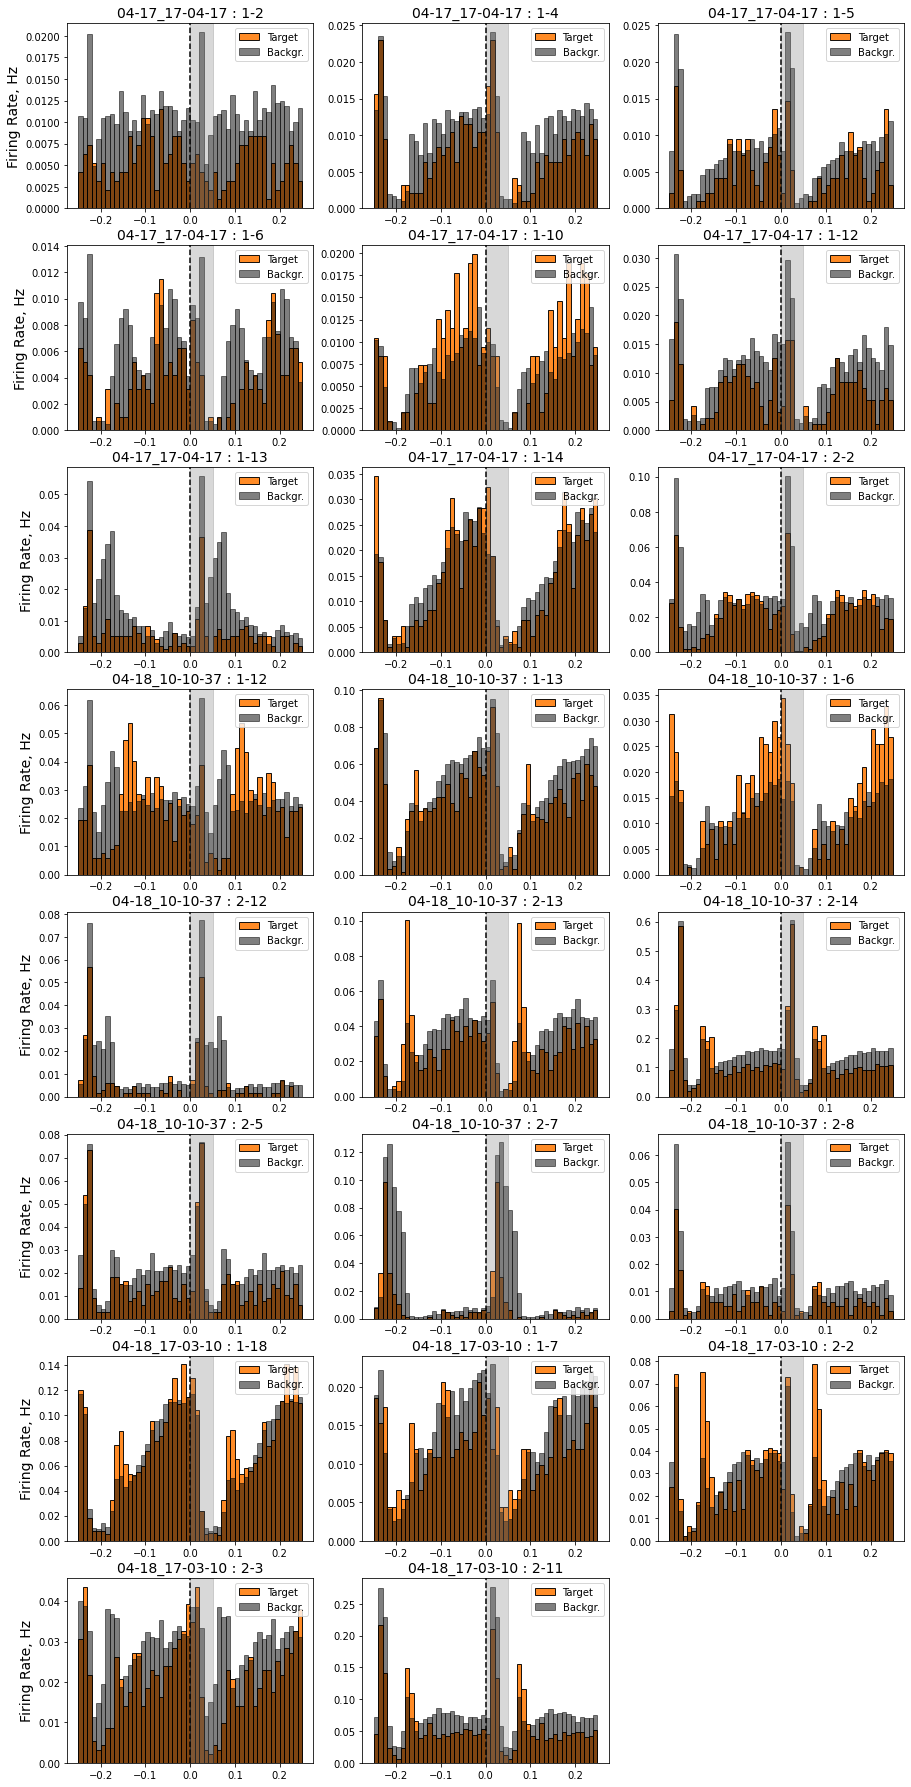

In [51]:
rows = int(np.ceil(unit_count/3))
fig = plt.figure(figsize=(15, rows*4))
count = 0

for session, unit_ids in example_units.items():
    # read AEP events
    animal    = session.split('_')[0]
    aeps_file = os.path.join(source, animal, session, 'AEPs.h5')
    with h5py.File(aeps_file, 'r') as f:
        aeps_events = np.array(f['aeps_events'])

    # read single units
    spike_times = {}
    h5_file = os.path.join(source, animal, session, session + '.h5')
    with h5py.File(h5_file, 'r') as f:
        for unit_id in unit_ids:
            spike_times[unit_id] = np.array(f['units'][unit_id][H5NAMES.spike_times['name']])
        
    for unit_id in unit_ids:
        bins, counts_bgr = get_spike_counts(spike_times[unit_id], aeps_events[aeps_events[:, 1] == 1][:, 0])
        bins, counts_tgt = get_spike_counts(spike_times[unit_id], aeps_events[aeps_events[:, 1] == 2][:, 0])

        ax = fig.add_subplot(rows, 3, count+1)
        ax.hist(bins[:-1], bins=bins, weights=counts_tgt, edgecolor='black', color='tab:orange', alpha=0.9, label='Target')
        ax.hist(bins[:-1], bins=bins, weights=counts_bgr, edgecolor='black', color='black', alpha=0.5, label='Backgr.')
        ax.axvline(0, color='black', ls='--')
        #ax.set_xlabel('Pulse onset, s', fontsize=14)
        ax.axvspan(0, 0.05, alpha=0.3, color='gray')
        ax.set_title("%s : %s" % (session[21:], unit_id), fontsize=14)
        ax.legend(loc='upper right', prop={'size': 10})
        if count % 3 == 0:
            ax.set_ylabel("Firing Rate, Hz", fontsize=14)
        count += 1
        
#fig.savefig(os.path.join(report_path, 'PSTH_tgt_bgr_%s-%s.pdf' % (p_from, p_to)))

### Figure notes: response micro-structure can be separated into different components

    Neuronal responses (PSTH) to target (green) / backgound (gray) for selected neurons.
    Gray shaded area - pulse duration (50 ms).
    Note modulation by the relevant sound differ in time relative to the pulse onset. 
    Let's name these phases as:
        - On           ~15-25  ms  Examples: almost all except 1-10
        - Off          ~30-75  ms  Examples: 2-12, 1-13 etc.
        - post-early   ~75-95  ms  Examples: 2-2, 2-3, 2-11, 1-6
        - post-late    ~95-175 ms  Examples: 2-11, 2-13, 2-14, 2-8 etc.
    Note each response phase can be either enhanced or suppressed by the target.

In [35]:
def plot_psth_by_metric(m_name, example_units):
    unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
    rows = int(np.ceil(unit_count/3))
    fig = plt.figure(figsize=(15, rows*4))
    count = 0

    for session, unit_ids in example_units.items():
        # read AEP events
        animal    = session.split('_')[0]
        aeps_file = os.path.join(source, animal, session, 'AEPs.h5')
        with h5py.File(aeps_file, 'r') as f:
            aeps_events = np.array(f['aeps_events'])
            aeps = np.array(f[area]['aeps'])

        # TODO find better way. Remove outliers
        aeps[aeps > 5000]  =  5000
        aeps[aeps < -5000] = -5000

        # read single units
        spike_times = {}
        h5_file = os.path.join(source, animal, session, session + '.h5')
        with h5py.File(h5_file, 'r') as f:
            for unit_id in unit_ids:
                spike_times[unit_id] = np.array(f['units'][unit_id][H5NAMES.spike_times['name']])

        # load metrics
        AEP_metrics_lims = {}
        AEP_metrics_raw  = {}
        AEP_metrics_norm = {}
        with h5py.File(aeps_file, 'r') as f:
            grp = f[area]
            for metric_name in grp['raw']:
                AEP_metrics_raw[metric_name]  = np.array(grp['raw'][metric_name])
                AEP_metrics_norm[metric_name] = np.array(grp['norm'][metric_name])
                AEP_metrics_lims[metric_name] = [int(x) for x in grp['raw'][metric_name].attrs['limits'].split(',')]

        # separate high / low AEP metric states
        predictor = AEP_metrics_norm[m_name]
        low_state_idxs  = np.where(predictor < predictor.mean())[0]
        high_state_idxs = np.where(predictor > predictor.mean())[0]
        aeps_low_mean  = aeps[low_state_idxs].mean(axis=0)
        aeps_high_mean = aeps[high_state_idxs].mean(axis=0)

        for unit_id in unit_ids:
            bins, counts_low  = get_spike_counts(spike_times[unit_id], aeps_events[low_state_idxs][:, 0])
            bins, counts_high = get_spike_counts(spike_times[unit_id], aeps_events[high_state_idxs][:, 0])

            vals_max = np.array([counts_high.max(), counts_low.max()]).max()
            aep_low_profile  = (1/10) * vals_max * (aeps_low_mean/500)
            aep_high_profile = (1/10) * vals_max * (aeps_high_mean/500)

            ax = fig.add_subplot(rows, 3, count+1)
            ax.hist(bins[:-1], bins=bins, weights=counts_high, edgecolor='black', color='red', alpha=0.8, label='%s >' % m_name)
            ax.hist(bins[:-1], bins=bins, weights=counts_low, edgecolor='black', color='black', alpha=0.5, label='%s <' % m_name)
            for x_l, x_r in [(-0.25, -0.051), (0.0, 0.199)]:
                ax.plot(np.linspace(x_l, x_r, len(aeps_low_mean)),  aep_high_profile, color='red', lw=2)
                ax.plot(np.linspace(x_l, x_r, len(aeps_high_mean)), aep_low_profile, color='black', lw=2)
            ax.axvline(0, color='black', ls='--')
            #ax.set_xlabel('Pulse onset, s', fontsize=14)
            ax.axvspan(0, 0.05, alpha=0.3, color='gray')
            ax.set_title("%s : %s" % (session[21:], unit_id), fontsize=14)
            ax.legend(loc='upper right', prop={'size': 10})
            if count % 3 == 0:
                ax.set_ylabel("Firing Rate, Hz", fontsize=14)
            count += 1

    return fig

## 2.2. AEP P1 state is modulated by ON-response units

In [36]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-2', '1-3', '1-4', '1-5', '1-6', '1-9', '1-12', '1-13', '1-15', '2-2', '2-3'
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-2', '1-3', '1-4', '1-9', '1-10', '2-2', '2-5', '2-7', '2-8', '2-11', '2-12'
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-2', '1-3', '1-6', '1-8', '1-9', '1-10', '1-12', '1-13', '2-2', '2-5', '2-6'
    ],
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

33

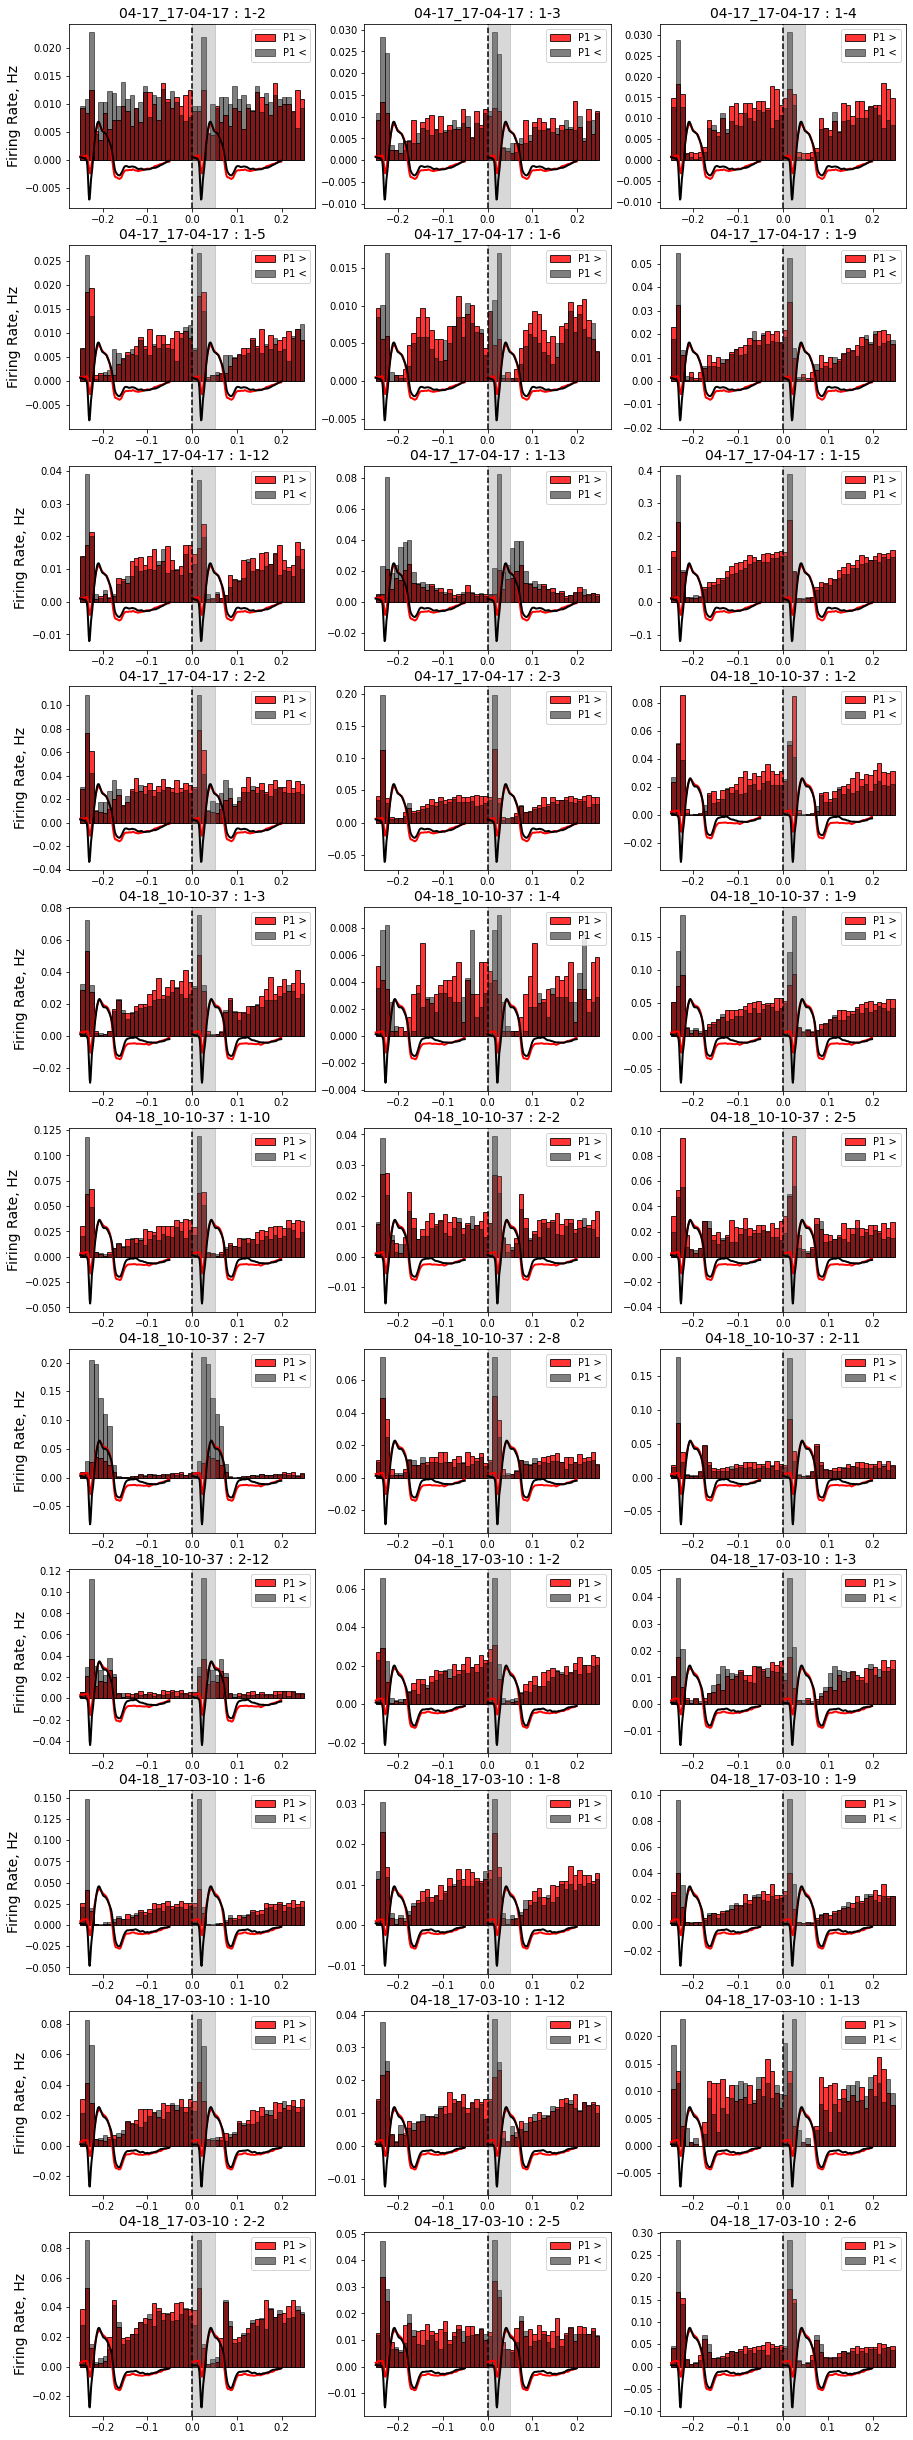

In [37]:
fig = plot_psth_by_metric('P1', example_units)

### Figure notes:

    PSTH for selected ON-response units (3 sessions) separated by the AEP P1 state (high / low).
    Red: AEP P1 (z-smoothed) above the mean - high; Black: AEP P1 (z-smoothed) below the mean - low.
    Mean AEP profile for high / low state are shown on top of PSTH in red / black respectively.
    Note strong modulation of the ON-response depending on the state.
    Note modulation can be positive (almost all cells) or negative (04-18_10-10-37 : 1-2, 2-5).
    Note in some cells P1 modulation is correlated with post-phase modulation (04-18_10-10-37 : 1-2, 04-17_17-04-17 : 1-6).
    Note high/low P1 state has almost no influence on the other components of the AEP profile.

## 2.3. AEP N1 state is modulated by OFF-response units

In [38]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-2', '1-6', '1-9', '1-10', '1-11', '1-13', '1-15'
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-5', '1-8', '2-3', '2-10', '2-12'
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-2', '1-7', '1-11', '1-12', '1-16', '1-18', '2-3', '2-5', '2-9'
    ],
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

21

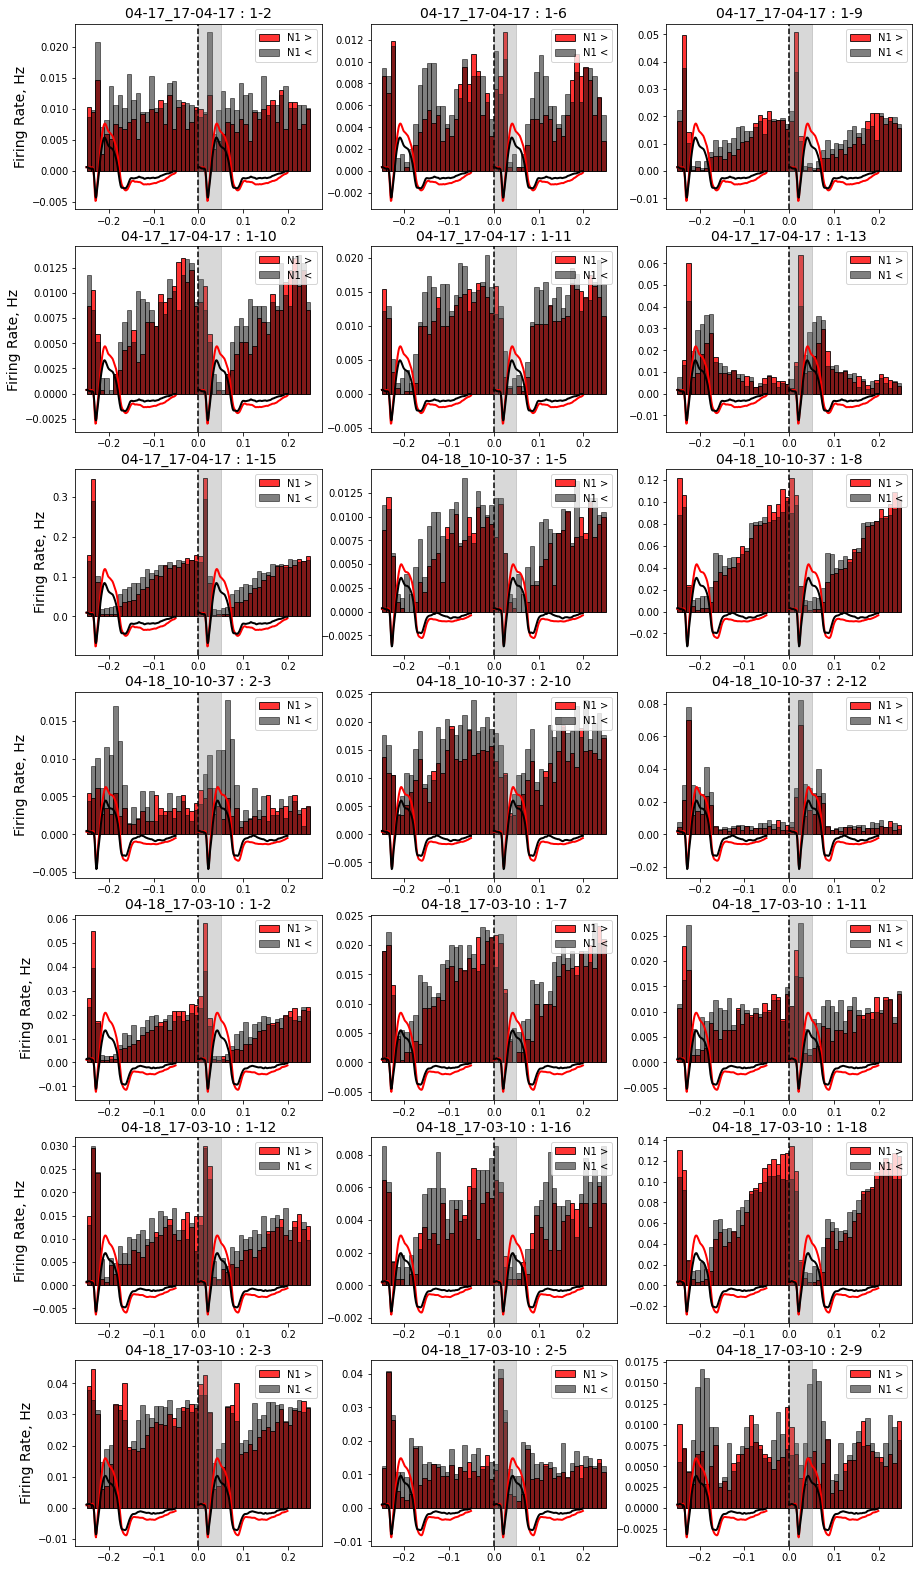

In [39]:
fig = plot_psth_by_metric('N1', example_units)

### Figure notes:

    PSTH for selected OFF-response units (3 sessions) separated by the AEP N1 state (high / low).
    Red: AEP N1 (z-smoothed) above the mean - high; Black: AEP N1 (z-smoothed) below the mean - low.
    Mean AEP profile for high / low N1 state are shown on top of PSTH in red / black respectively.
    Note some units are strongly modulated int the OFF-phase of the response depending on the state.
    Note in many cells N1 modulation is correlated with post-phases modulation (after the OFF-response).
    Note high/low N1 state is correlated with high/low P3 state in different sessions (to be explored).

## 2.4. AEP P2 state is modulated by post-early response units

In [44]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-7', '1-10', '1-11', '1-12', '1-13', '1-14',
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-3', '1-6', '1-8', '2-2', '2-3', '2-4', '2-6', '2-9', '2-10', '2-11', '2-13', '2-14', 
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-13', '1-18', '2-11', '2-2', '2-3', '2-4', '2-6', '2-7', '2-9'
    ],
    '009266_hippoSIT_2023-04-19_10-33-51': [
        '1-2', '1-3', '2-2', '2-5', '2-6'
    ]
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

32

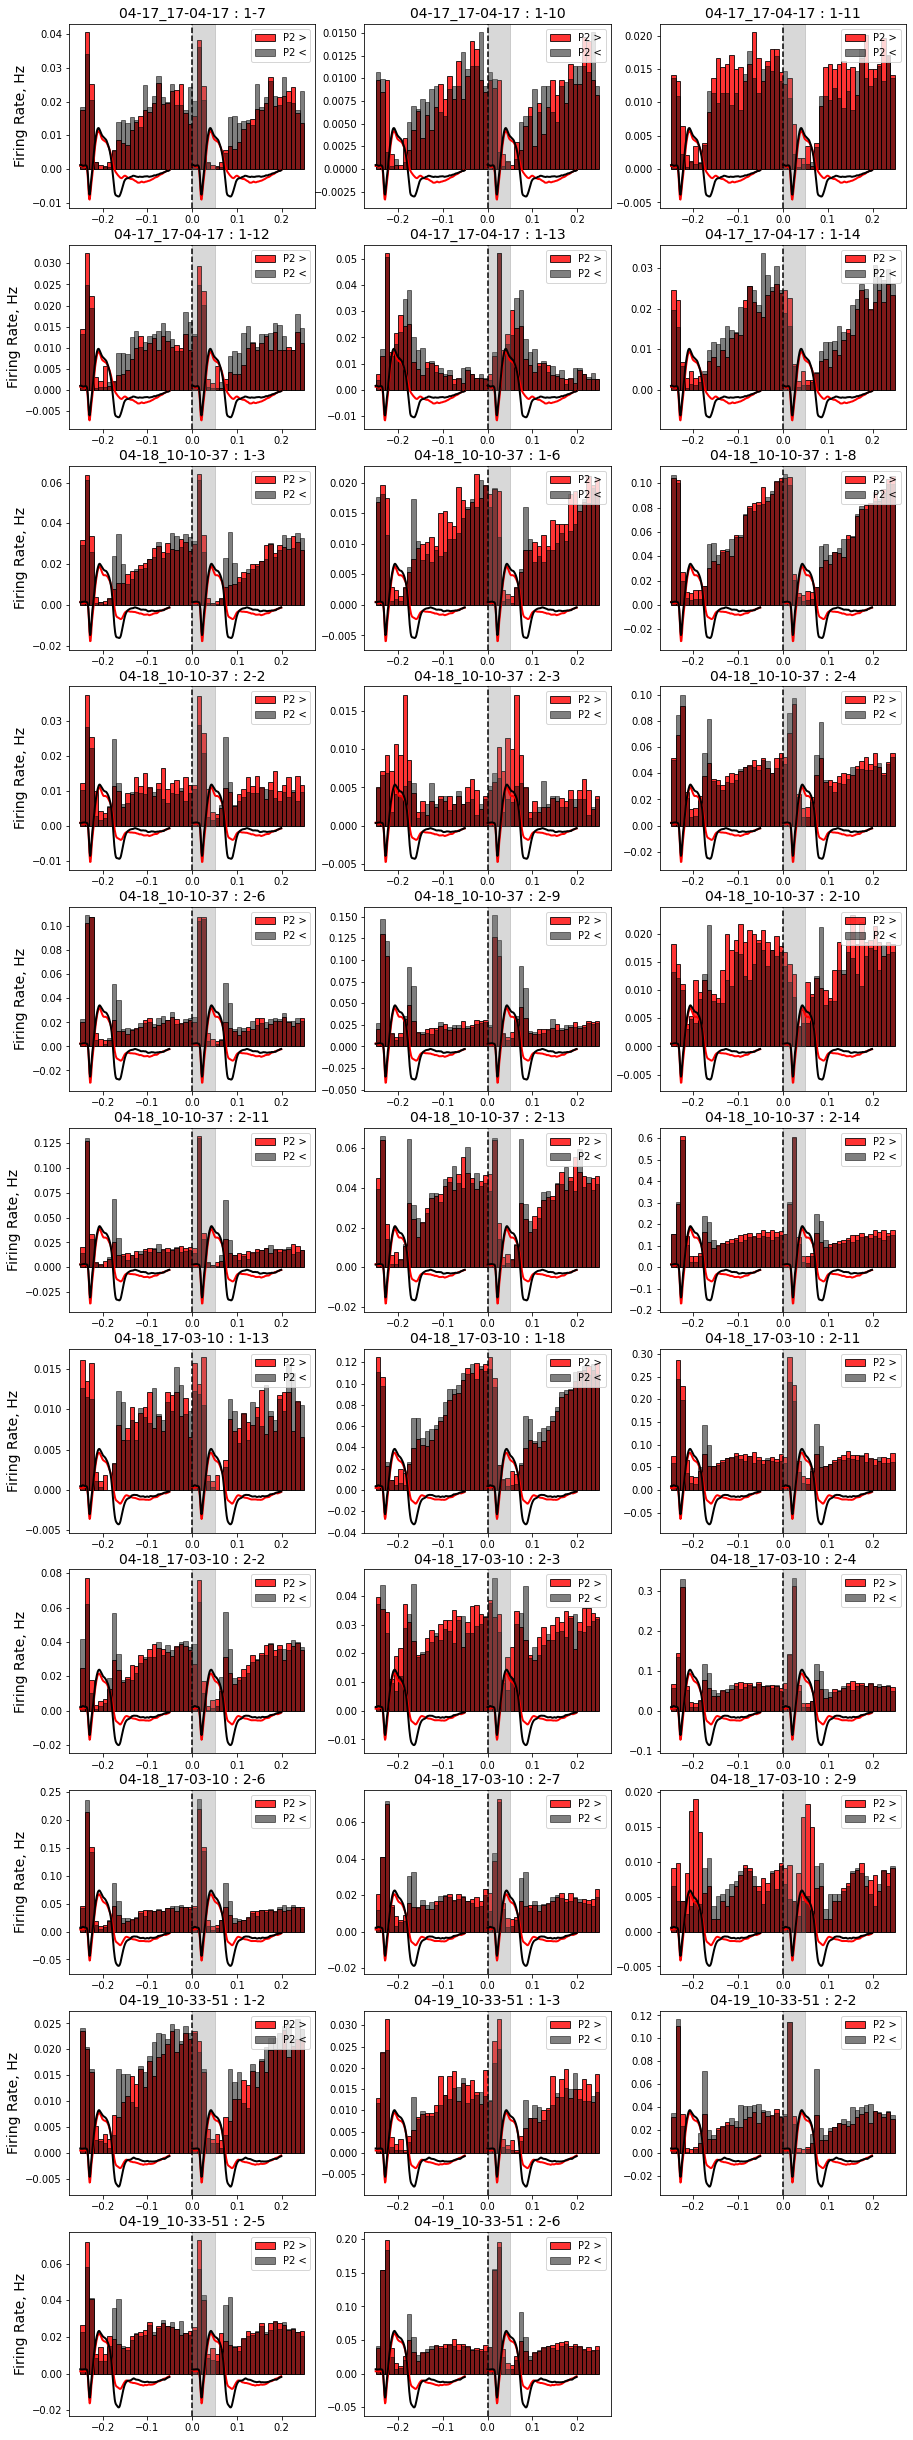

In [45]:
fig = plot_psth_by_metric('P2', example_units)

### Figure notes:

    PSTH for selected post-early response units (4 sessions) separated by the AEP P2 state (high / low).
    Red: AEP P2 (z-smoothed) above the mean - high; Black: AEP P2 (z-smoothed) below the mean - low.
    Mean AEP profile for high / low P2 state are shown on top of PSTH in red / black respectively.
    Note some units are strongly modulated int the post-early phase of the response depending on the state.
    Note in many cells P2 modulation is correlated with OFF modulation.
    Note high/low P2 state is only slightly correlates with high/low P3 state in different sessions (to be explored).

## 2.5. AEP P3 state is modulated by post-late response units

In [46]:
example_units = {
    '009266_hippoSIT_2023-04-17_17-04-17': [
        '1-3', '1-7', '1-12'
    ],
    '009266_hippoSIT_2023-04-18_10-10-37': [
        '1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '2-2', '2-4', '2-5', '2-6', '2-9', '2-13', '2-14', 
    ],
    '009266_hippoSIT_2023-04-18_17-03-10': [
        '1-5', '1-8', '1-13', '1-14', '1-16', '1-18', '2-2', '2-8', '2-9'
    ],
    '009266_hippoSIT_2023-04-19_10-33-51': [
        '1-2', '1-3', '1-4', '1-5', '1-7', '1-8', '1-9', '1-10', '1-11', '1-12', '1-13', '1-14', '1-16', \
        '1-19', '2-4'
    ]
}

unit_count = np.array([len(vals) for vals in example_units.values()]).sum()
unit_count

42

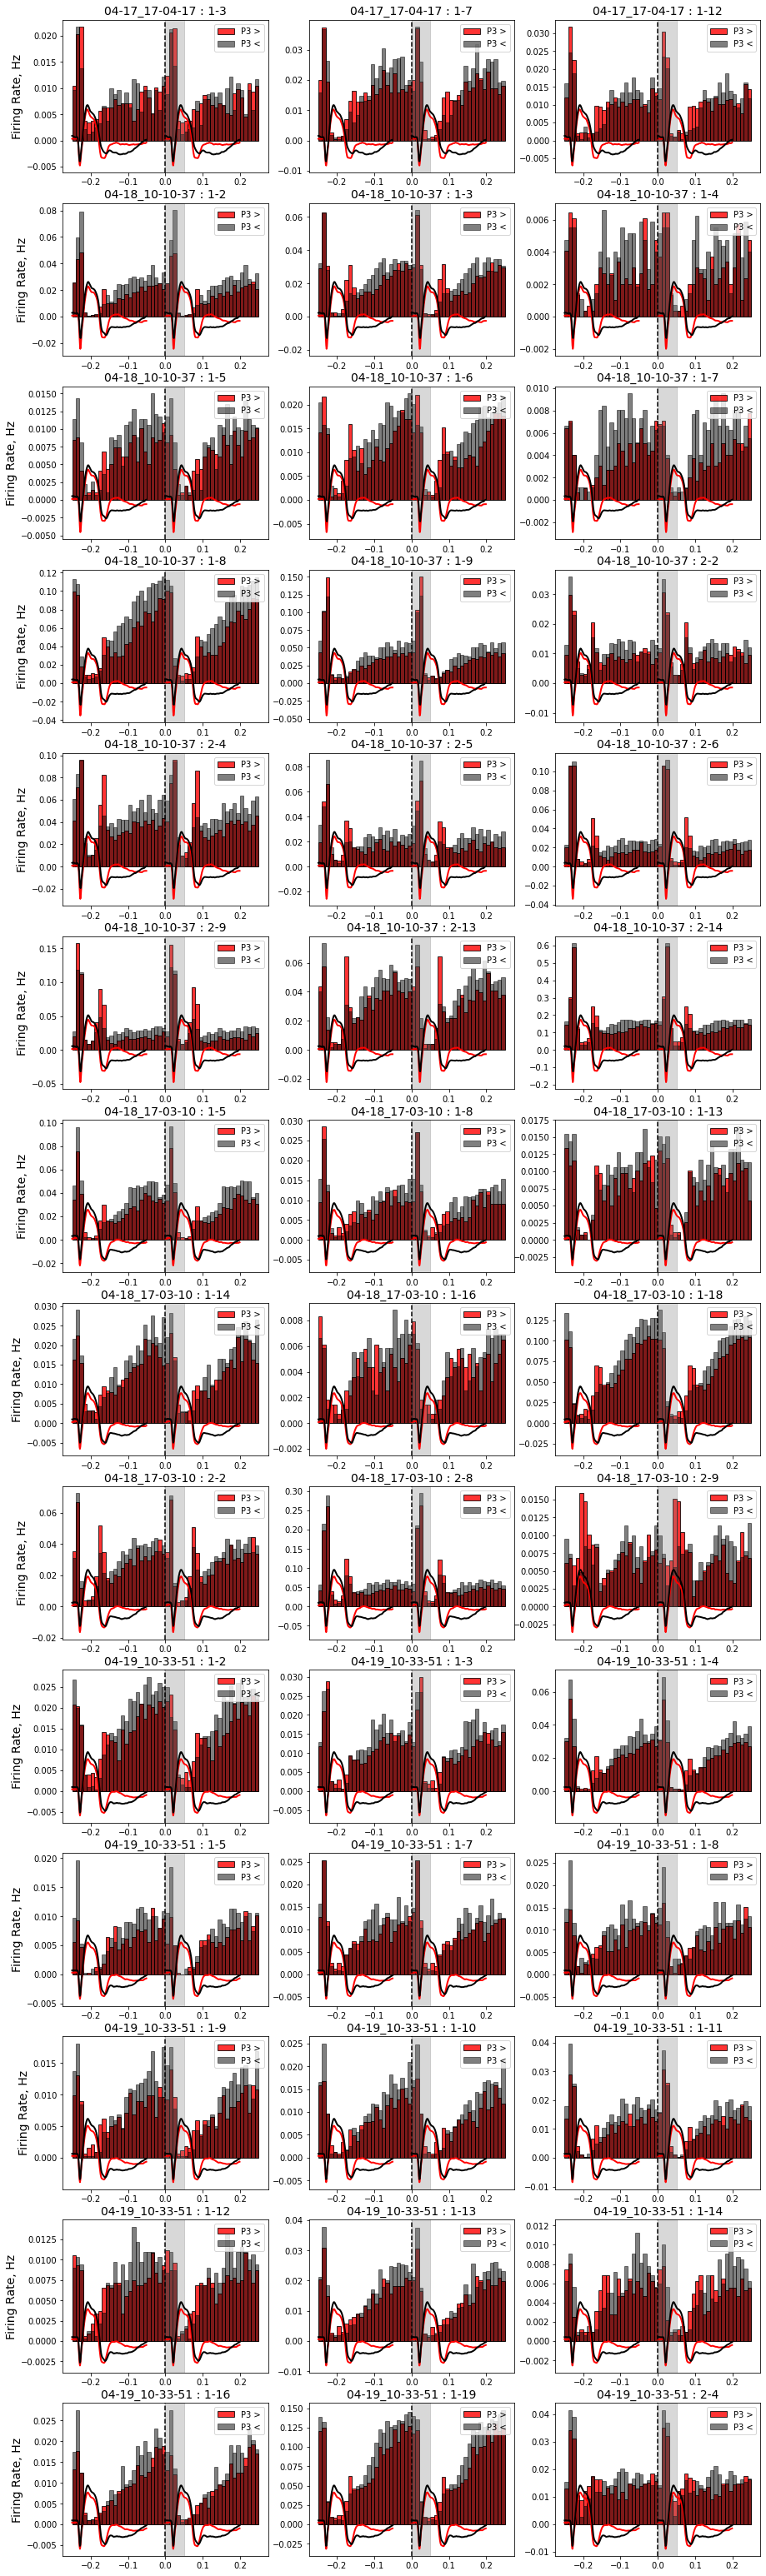

In [47]:
fig = plot_psth_by_metric('P3', example_units)

### Figure notes:

    PSTH for selected post-early response units (4 sessions) separated by the AEP P3 state (high / low).
    Red: AEP P3 (z-smoothed) above the mean - high; Black: AEP P3 (z-smoothed) below the mean - low.
    Mean AEP profile for high / low P3 state are shown on top of PSTH in red / black respectively.
    Note some units are strongly modulated int the post-early phase of the response depending on the state.
    Note in many cells P3 modulation is correlated with OFF modulation.
    Note high/low P3 state slightly correlates with high/low N1 state in different sessions (to be explored).

## 2.6. Population activity of ON, OFF, post-early and post-late phase neurons drive corresponding P1, N1, P2 and P3 components of evoked responses

In [41]:
# To be implemented
# 1. Find the best way to separate neurons in ON, OFF, post-early and post-late phase groups
# 2. Compute average population responses for each phase and correlate with strength of AEP components
# 3. Don't forget controls: show it works only for those groups, only for particular phase etc.

## 2.7 Unit selectivity matrices: which neurons have which components?

In [42]:
# To be implemented